# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)
data_file_train = 'mitbih_train.csv'
data_file_test = 'mitbih_test.csv'

In [3]:
df_train = pd.read_csv(data_folder+data_file_train, header=None)
df_test = pd.read_csv(data_folder+data_file_test, header=None)

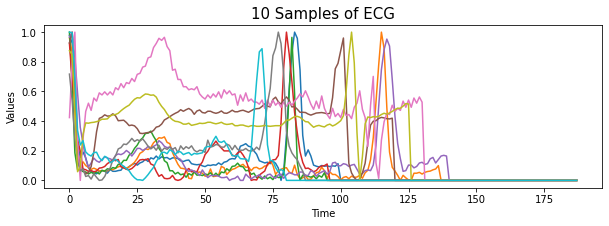

In [4]:
plt.figure(figsize=(10,3))
plt.plot(df_train.iloc[:10, :].T)
plt.title("10 Samples of ECG", fontsize=15)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Values", fontsize=10)
plt.show()

In [5]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch
from torch.autograd import Variable

import os
import statistics
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

import sys
sys.setrecursionlimit(15000)

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [6]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = torch.Tensor(data)
        self.used_cols = [x for x in range(data.shape[1]-1)] 
        
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

    def __getitem__(self, index):
        x = self.data[index, self.used_cols].unsqueeze(1).T
        y = self.data[index, -1]
        return x, y

    def __len__(self):
        return len(self.data) 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape) 
    
    def __getsize__(self):
        return (self.__len__())

In [7]:
batch_size = 64
num_workers = 4
pin_memory = True
NUM_CLASSES = 5
device = 'cuda'
num_epoch = 200
lr = 1e-4
NUM_ROUTING_ITERATIONS=3

In [8]:
print(len(df_train), len(df_test))

87554 21892


In [9]:
### Stratify Test Dataset to Test/Valid ###
from sklearn.model_selection import train_test_split

train_dataset = MyDataset(df_train.values)

x_valid, x_test, y_valid, y_test = train_test_split(df_test.iloc[:,:-1],df_test.iloc[:,-1], test_size=0.5, shuffle=True, stratify=df_test.iloc[:,-1], random_state=SEED)
df_valid = pd.DataFrame(x_valid)
df_valid.insert(len(df_valid.columns), "target", pd.Series(y_valid))

df_test = pd.DataFrame(x_test)
df_test.insert(len(df_test.columns), "target", pd.Series(y_test))

valid_dataset = MyDataset(df_valid.values)
test_dataset = MyDataset(df_test.values)

In [10]:
### train / valid / test data length ###
print(len(df_train), len(df_valid), len(df_test))

87554 10946 10946


In [11]:
### train label counts ###
df_train.iloc[:, -1] = df_train.iloc[:, -1].values.astype(int)
df_train.iloc[:, -1].value_counts()

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64

In [12]:
### valid label counts ###
df_valid.iloc[:, -1] = df_valid.iloc[:, -1].values.astype(int)
df_valid.iloc[:, -1].value_counts()

0    9059
4     804
2     724
1     278
3      81
Name: target, dtype: int64

In [13]:
### test label counts ###
df_test.iloc[:, -1] = df_test.iloc[:, -1].values.astype(int)
df_test.iloc[:, -1].value_counts()

0    9059
4     804
2     724
1     278
3      81
Name: target, dtype: int64

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=True) 
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# 2. DR-CapsNet Model 

In [15]:
result_folder = '../check/drcaps/classirecon/'
os.makedirs(result_folder, exist_ok=True)

attack_result_folder = '../check/drcaps/classirecon_attack/'
os.makedirs(attack_result_folder, exist_ok=True)

In [16]:
def softmax(input, dim=1):
    transposed_input = input.transpose(dim, len(input.size()) - 1)
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input.size()) - 1)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn import manifold
import umap


def squash(inputs, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param inputs: vectors to be squashed
    :param axis: the axis to squash
    :return: a Tensor with same size as inputs
    """
    norm = torch.norm(inputs, p=2, dim=axis, keepdim=True)
    scale = norm**2 / (1 + norm**2) / (norm + 1e-8)
    return scale * inputs


class DenseCapsule(nn.Module):
    """
    The dense capsule layer. It is similar to Dense (FC) layer. Dense layer has `in_num` inputs, each is a scalar, the
    output of the neuron from the former layer, and it has `out_num` output neurons. DenseCapsule just expands the
    output of the neuron from scalar to vector. So its input size = [None, in_num_caps, in_dim_caps] and output size = \
    [None, out_num_caps, out_dim_caps]. For Dense Layer, in_dim_caps = out_dim_caps = 1.
    :param in_num_caps: number of cpasules inputted to this layer
    :param in_dim_caps: dimension of input capsules
    :param out_num_caps: number of capsules outputted from this layer
    :param out_dim_caps: dimension of output capsules
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, in_num_caps, in_dim_caps, out_num_caps, out_dim_caps, routings=3, affine=None, coupling=None):
        super(DenseCapsule, self).__init__()
        self.in_num_caps = in_num_caps
        self.in_dim_caps = in_dim_caps
        self.out_num_caps = out_num_caps
        self.out_dim_caps = out_dim_caps
        self.routings = routings
        self.affine = affine
        self.coupling = coupling
        
        self.weight = nn.Parameter(0.01 * torch.randn(out_num_caps, in_num_caps, out_dim_caps, in_dim_caps))

    def visualize_weight(self, weight, num_filter, layer, classi, attack):
        class_num, in_num_caps, out_dim_caps, in_dim_cpas = weight.size()
        tmp = weight[classi, :, :, :].detach().cpu()
        tmp = tmp.reshape(4,-1,out_dim_caps, in_dim_cpas)
        fig, ax = plt.subplots(4,4,dpi=150)
        for i in range(4):
            for j in range(4):
                sns.heatmap(tmp[i, j,:,:].T, ax = ax[i, j], cbar=False)
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
        fig.suptitle(layer+f" feature heatmap - {classi}class (16capsules)", fontsize=15)
        fig.supxlabel("16 Out Capsule Dimension", fontsize=10)
        fig.supylabel("8 In Capsule Dimension", fontsize=10)
        if attack == None:
            plt.savefig(result_folder + f'dr_{layer}_heatmap.png')
        else:
            plt.savefig(attack_result_folder + f'dr_{layer}_heatmap.png')
            
        tmp = weight[:, 0, :, :].detach().cpu()
        tmp = tmp.reshape(5,out_dim_caps, in_dim_cpas)
        fig, ax = plt.subplots(2,3,dpi=150)
        cnt = 0
        for i in range(2):
            for j in range(3):
                if cnt == 5:
                    ax[i,j].set_xticks([])
                    ax[i,j].set_yticks([])
                    break
                sns.heatmap(tmp[cnt, :,:].T, ax = ax[i, j], cbar=False)
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                cnt += 1
        fig.suptitle(layer+f" feature heatmap - first capsule (5 classes)", fontsize=15)
        fig.supxlabel("16 Out Capsule Dimension", fontsize=10)
        fig.supylabel("8 In Capsule Dimension", fontsize=10)
        if attack == None:
            plt.savefig(result_folder+ f'dr_{layer}_heatmap2.png')
        else:
            plt.savefig(attack_result_folder + f'dr_{layer}_heatmap2.png')
        
    def visualize_uhat(self, uhat, num_filter, layer, num, class_num, attack):
        batch, out_num_caps, in_num_caps, out_dim_cpas = uhat.size()
        tmp = uhat[num, class_num, :, :].detach().cpu()
        r = int(math.sqrt(num_filter))
        c = int(math.sqrt(num_filter))

        tmp = tmp.reshape(r,-1,1, out_dim_cpas)
        fig, ax = plt.subplots(r,c,dpi=150)
        for i in range(r):
            for j in range(c):
                ax[i, j].plot(tmp[i, j, :, :].T)
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
        fig.suptitle(layer+f" feature map - {class_num}class (16capsules)", fontsize=15)
        fig.supxlabel("16 Out Capsule Dimension", fontsize=10)
        fig.supylabel("Values", fontsize=10)
        if attack == None:
            plt.savefig(result_folder + f'dr_{layer}.png')
        else:
            plt.savefig(attack_result_folder + f'dr_{layer}.png')
            
        tmp = uhat[num, :, 0, :].detach().cpu()
        tmp = tmp.reshape(5,1, out_dim_cpas)
        fig, ax = plt.subplots(2,3,dpi=150)
        cnt = 0
        for i in range(2):
            for j in range(3):
                if cnt == 5:
                    ax[i,j].set_xticks([])
                    ax[i,j].set_yticks([])
                    break
                ax[i, j].plot(tmp[cnt, :,:].T)
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
                cnt += 1
        fig.suptitle(layer+f" feature heatmap - first capsule (5 classes)", fontsize=15)
        fig.supxlabel("16 Out Capsule Dimension", fontsize=10)
        fig.supylabel("Values", fontsize=10)
        if attack == None:
            plt.savefig(result_folder + f'dr_{layer}2.png')
        else:
            plt.savefig(attack_result_folder + f'dr_{layer}2.png')
        
    def visualize_cc(self, cc, layer, num, attack):
        batch, out_num_caps, in_num_caps = cc.size()
        tmp = cc[num].detach().cpu().numpy()
        
        #print(torch.unique(cc[num]), np.unique(tmp))

        plt.figure(dpi=150)
        sns.heatmap(tmp, cbar=True)
        plt.title(layer+" feature heatmap", fontsize=15)
        plt.xlabel(f"{num}sample's 2752(t*h) in-capsules", fontsize=10)
        plt.ylabel(f"{num}sample's 5 out-capsules(classes)", fontsize=10)
        if attack == None:
            plt.savefig(result_folder + f'dr_{layer}_heatmap.png')
        else:
            plt.savefig(attack_result_folder+f'dr_{layer}_heatmap.png')
            
        #print(np.unique(tmp))
        plt.figure(dpi=150)
        sns.distplot(tmp, norm_hist=False)
        plt.title(layer+" feature heatmap", fontsize=15)
        plt.xlabel(f"{num}sample's 2752(t*h) in-capsules", fontsize=10)
        plt.ylabel(f"density", fontsize=10)
        if attack == None:
            plt.savefig(result_folder+f'dr_{layer}_histogram.png')
        else:
            plt.savefig(attack_result_folder + f'dr_{layer}_histogram.png')
        
    def visualize_u_uhat(self, u, uhat, num, attack):
        batch, in_num_caps, in_dim_caps = u.size()
        batch, out_num_caps, in_num_caps, out_dim_cpas = uhat.size()
        
        m = nn.ConstantPad1d(4, 0)
        u_ = m(u[num]).detach().cpu().numpy()
        uhat_ = uhat[num]
        
        data = u_
        fig = plt.figure(dpi=150)
        ax = fig.add_subplot(111, projection='3d')
        cnt = [len(data)]
        for i in range(5):
            data = np.concatenate((data, uhat_[i].detach().cpu().numpy()), axis=0)
            cnt.append(len(data))

        #trans_data = tsne.fit_transform(data)
        trans_data = umap.UMAP(n_components=3, random_state=SEED, metric='euclidean').fit_transform(data) #cosine, correlation ,euclidean
        ax.scatter(trans_data[:,0][0:cnt[0]], trans_data[:,1][0:cnt[0]], trans_data[:,2][0:cnt[0]], c= 'r', s = 1, marker='.', label='u')
        ax.scatter(trans_data[:,0][cnt[0]:cnt[1]], trans_data[:,1][cnt[0]:cnt[1]], trans_data[:,2][cnt[0]:cnt[1]], c= 'b', alpha=.3, s = .5, marker='x', label='0uhat')
        ax.scatter(trans_data[:,0][cnt[1]:cnt[2]], trans_data[:,1][cnt[1]:cnt[2]], trans_data[:,2][cnt[1]:cnt[2]], c= 'orange', alpha=.3,s = .5, marker='+', label='1uhat')
        ax.scatter(trans_data[:,0][cnt[2]:cnt[3]], trans_data[:,1][cnt[2]:cnt[3]], trans_data[:,2][cnt[2]:cnt[3]], c= 'green', alpha=.3, s = .5, marker='x', label='2uhat')
        ax.scatter(trans_data[:,0][cnt[3]:cnt[4]], trans_data[:,1][cnt[3]:cnt[4]], trans_data[:,2][cnt[3]:cnt[4]], c= 'black', alpha=.3, s = .5, marker='x', label='3uhat')
        ax.scatter(trans_data[:,0][cnt[4]:], trans_data[:,1][cnt[4]:], trans_data[:,2][cnt[4]:], c= 'purple', s = .5, marker='x', alpha=.3, label='4uhat')
        plt.legend()
        plt.title("U-Uhat Relationship", fontsize=15)
        if attack == None:
            plt.savefig(result_folder+f'dr_u_uhat_umap.png')
        else:
            plt.savefig(attack_result_folder+f'dr_u_uhat_umap.png')
            
    def visualize_uhat_v(self, uhat, v, num, attack):
        batch, out_num_caps, in_num_caps, out_dim_cpas = uhat.size()
        batch_v, out_num_caps_v, w, out_dim_caps_v = v.size()
        
        uhat_ = uhat[num]
        v_ = v[num].detach().cpu().numpy()
        
        plt.figure(dpi=150)
        #ax = fig.add_subplot(111, projection='3d')
        
        data = v_[0]
        for i in range(1,5):
            data = np.concatenate((data, v_[i]), axis=0)
        cnt = [len(data)]
            
        for i in range(5):
            for j in range(in_num_caps):
                data = np.concatenate((data, uhat_[i, j].unsqueeze(0).detach().cpu().numpy()), axis=0)
            cnt.append(len(data))
            
        trans_data = umap.UMAP(n_components=2, random_state=SEED, metric='cosine').fit_transform(data)
        
        plt.scatter(trans_data[:,0][cnt[0]:cnt[1]], trans_data[:,1][cnt[0]:cnt[1]], c= 'r', s = .5, marker='.', label='0uhat')#, trans_data[:,2][cnt[0]:cnt[1]]
        plt.scatter(trans_data[:,0][cnt[1]:cnt[2]], trans_data[:,1][cnt[1]:cnt[2]], c= 'b', alpha=.3, s = .5, marker='.', label='1uhat') #, trans_data[:,2][cnt[1]:cnt[2]]
        plt.scatter(trans_data[:,0][cnt[2]:cnt[3]], trans_data[:,1][cnt[2]:cnt[3]], c= 'orange', alpha=.3,s = .5, marker='.', label='2uhat')#, trans_data[:,2][cnt[2]:cnt[3]]
        plt.scatter(trans_data[:,0][cnt[3]:cnt[4]], trans_data[:,1][cnt[3]:cnt[4]], c= 'green', alpha=.3, s = .5, marker='.', label='3uhat')#, trans_data[:,2][cnt[3]:cnt[4]]
        plt.scatter(trans_data[:,0][cnt[4]:cnt[5]], trans_data[:,1][cnt[4]:cnt[5]], c= 'purple', alpha=.3, s = .5, marker='.', label='4uhat')#, trans_data[:,2][cnt[4]:cnt[5]]
        #ax.scatter(trans_data[:,0][cnt[4]:], trans_data[:,1][cnt[4]:], trans_data[:,2][cnt[4]:], c= 'purple', s = .5, marker='x', alpha=.3, label='4uhat')
        plt.scatter(trans_data[:,0][0:cnt[0]], trans_data[:,1][0:cnt[0]], c= 'black', s = 30, marker='o', label='v')#, trans_data[:,2][0:cnt[0]]
        plt.title("V-Uhat Relationship", fontsize=15)
        plt.legend()
        if attack == None:
            plt.savefig(result_folder+f'dr_v_uhat_umap.png')
        else:
            plt.savefig(attack_result_folder+f'dr_v_uhat_umap.png')
        
    def forward(self, x, visualize=False, num = 0, class_num=0, attack=None):
        """
        # x.size=[batch, in_num_caps, in_dim_caps]
        # expanded to    [batch, 1,            in_num_caps, in_dim_caps,  1]
        # weight.size   =[       out_num_caps, in_num_caps, out_dim_caps, in_dim_caps]
        # torch.matmul: [out_dim_caps, in_dim_caps] x [in_dim_caps, 1] -> [out_dim_caps, 1]
        # => x_hat.size =[batch, out_num_caps, in_num_caps, out_dim_caps]
        """
        
        if visualize == True:
            self.visualize_weight(self.weight, 16, "Affine Transformation Matrix", class_num, attack)
        x_hat = torch.squeeze(torch.matmul(self.weight, x[:, None, :, :, None]), dim=-1)
        if visualize == True:
            #self.visualize_uhat(x_hat, 16, "Uhat", num, class_num, attack)
            self.visualize_u_uhat(x, x_hat, num, attack)
        
        """
        # In forward pass, `x_hat_detached` = `x_hat`;
        # In backward, no gradient can flow from `x_hat_detached` back to `x_hat`.
        """
        x_hat_detached = x_hat.detach()
        
        """
        # The prior for coupling coefficient, initialized as zeros.
        # b.size = [batch, out_num_caps, in_num_caps]
        """
        b = Variable(torch.zeros(x.size(0), self.out_num_caps, self.in_num_caps).to(device))

        assert self.routings > 0, 'The \'routings\' should be > 0.'
        for i in range(self.routings):
            # c.size = [batch, out_num_caps, in_num_caps]
            c = F.softmax(b, dim=1)
            if visualize==True:
                self.visualize_cc(c, f"Coupling Coefficient after {i}routing", num, attack)
            
            # At last iteration, use `x_hat` to compute `outputs` in order to backpropagate gradient
            if i == self.routings - 1:
                """
                # c.size expanded to [batch, out_num_caps, in_num_caps, 1           ]
                # x_hat.size     =   [batch, out_num_caps, in_num_caps, out_dim_caps]
                # => outputs.size=   [batch, out_num_caps, 1,           out_dim_caps]
                """
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat, dim=-2, keepdim=True))
            else:  # Otherwise, use `x_hat_detached` to update `b`. No gradients flow on this path.
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat_detached, dim=-2, keepdim=True))
                """
                # outputs.size       =[batch, out_num_caps, 1,           out_dim_caps]
                # x_hat_detached.size=[batch, out_num_caps, in_num_caps, out_dim_caps]
                # => b.size          =[batch, out_num_caps, in_num_caps]
                """
                b = b + torch.sum(outputs * x_hat_detached, dim=-1)
                
        if visualize==True:
            self.visualize_uhat_v(x_hat, outputs, num, attack)

        return torch.squeeze(outputs, dim=-2)


class PrimaryCapsule(nn.Module):
    """
    Apply Conv2D with `out_channels` and then reshape to get capsules
    :param in_channels: input channels
    :param out_channels: output channels
    :param dim_caps: dimension of capsule
    :param kernel_size: kernel size
    :return: output tensor, size=[batch, num_caps, dim_caps]
    """
    def __init__(self, in_channels, out_channels, dim_caps, kernel_size, stride=1, padding=0):
        super(PrimaryCapsule, self).__init__()
        self.dim_caps = dim_caps
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        outputs = self.conv2d(x)
        outputs = outputs.view(x.size(0), -1, self.dim_caps)
        return squash(outputs)

2023-03-19 12:27:07.552879: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [19]:
class CapsuleNet(nn.Module):
    """
    A Capsule Network on MNIST.
    :param input_size: data size = [channels, width, height]
    :param classes: number of classes
    :param routings: number of routing iterations
    Shape:
        - Input: (batch, channels, width, height), optional (batch, classes) .
        - Output:((batch, classes), (batch, channels, width, height))
    """
    def __init__(self, input_size, classes, routings, affine=None, coupling=None):
        super(CapsuleNet, self).__init__()
        self.input_size = input_size
        self.classes = classes
        self.routings = routings
        self.affine = affine
        self.coupling = coupling

        # Layer 1: Just a conventional Conv2D layer
        self.conv1 = nn.Conv2d(input_size[0], 256, kernel_size=(1,9), stride=1, padding=0)

        # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_caps, dim_caps]
        self.primarycaps = PrimaryCapsule(256, 256, 8, kernel_size=(1,9), stride=(1,2), padding=0)

        # Layer 3: Capsule layer. Routing algorithm works here.
        self.digitcaps = DenseCapsule(in_num_caps=32*86, in_dim_caps=8,
                                      out_num_caps=classes, out_dim_caps=16, routings=routings,
                                      affine=self.affine, coupling=self.coupling) # replacing affine matrix with 'uniform' or ;random' matrix
                                     # replacing coupling coefficient with 'uniform' or 'random' matrix

        # Decoder network.
        self.decoder = nn.Sequential(
            nn.Linear(16*classes, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, input_size[0] * input_size[1] * input_size[2]),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU()
        
    def visualize(self, x, num_filter, layer, num, attack):
        x = x.detach().cpu()[num]
        r = int(math.sqrt(num_filter))
        c = int(math.sqrt(num_filter))
        x = x.reshape(r,c,1, -1)
        _, _, _, t = x.size()
        fig, ax = plt.subplots(r,c,dpi=150)
        for i in range(r):
            for j in range(c):
                ax[i, j].plot(x[i, j, :, :].T)
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
        fig.suptitle(layer+" feature map (1box=1channel)", fontsize=15)
        if num_filter == 16:
            fig.supxlabel(f"Class Length ({t})", fontsize=10)
        else:
            fig.supxlabel(f"Time Length ({t})", fontsize=10)
        fig.supylabel("Valeus",fontsize=10)
        if attack == None:
            plt.savefig(result_folder+f'dr_{layer}.png')
        else:
            plt.savefig(attack_result_folder+f'dr_{layer}.png')
    
    def visualize_primarycaps(self, x, num_filter, layer, num, attack):
        x = x.detach().cpu()[num]
        r = int(math.sqrt(num_filter))
        c = int(math.sqrt(num_filter))
        x = x.reshape(r,-1,1, 8)
        fig, ax = plt.subplots(r,c,dpi=150)
        for i in range(r):
            for j in range(c):
                ax[i, j].plot(x[i, j, :, :].T)
                ax[i, j].set_xticks([])
                ax[i, j].set_yticks([])
        fig.suptitle(layer+" feature map (1box=1capsule)", fontsize=15)
        fig.supxlabel("Capsule Dimension (8)", fontsize=10)
        fig.supylabel("Values", fontsize=10)
        if attack == None:
            plt.savefig(result_folder+f'dr_{layer}2.png')
        else:
            plt.savefig(attack_result_folder+f'dr_{layer}2.png')
        
    def visualize_digitcaps(self, x, num_filter, layer, num, attack):
        x = x.detach().cpu()[num]
        r = num_filter
        x = x.reshape(r,1, 16)
        fig, ax = plt.subplots(2, 3, dpi=150)
        cnt = 0
        for i in range(2):
            for j in range(3):
                if cnt == num_filter:
                    ax[i,j].set_xticks([])
                    ax[i,j].set_yticks([])
                    break
                ax[i,j].plot(x[cnt, :, :].T)
                ax[i,j].set_xticks([])
                ax[i,j].set_yticks([])
                cnt += 1
        fig.suptitle(layer+" feature map (1box=1capsule)", fontsize=15)
        fig.supxlabel("Capsule Dimension (16)", fontsize=10)
        fig.supylabel("Values", fontsize=10)
        if attack == None:
            plt.savefig(result_folder+f'dr_{layer}2.png')
        else:
            plt.savefig(attack_result_folder+f'dr_{layer}2.png')
    
    def visualize2(self, x, num_filter, layer, num, attack):
        x = x.detach().cpu()[num].squeeze()
        plt.figure(figsize=(10,3))
        plt.plot(x)
        plt.title(layer, fontsize=20)
        if attack == None:
            plt.savefig(result_folder+f'dr_{layer}.png')
        else:
            plt.savefig(attack_result_folder+f'dr_{layer}.png')

    def forward(self, x, y=None, visualize=False, num = 0, class_num=0, attack=None):
        if visualize==True:
            x = self.relu(self.conv1(x.unsqueeze(1)))
            #self.visualize(x, 256, "ReLU-Conv layer", num, attack)
            x = self.primarycaps(x)
            #self.visualize(x, 256, "Primary-Caps layer", num, attack)
            #self.visualize_primarycaps(x, 16, 'Primary-Caps layer', num, attack)
            x = self.digitcaps(x, True, num, class_num, attack)
            #self.visualize(x, 16, "Digit-Caps layer",num, attack)
            #self.visualize_digitcaps(x, 5, "Digit-Caps layer",num, attack)
            length = x.norm(dim=-1)
            if y is None:  # during testing, no label given. create one-hot coding using `length`
                index = length.max(dim=1)[1]
                y = Variable(torch.zeros(length.size()).scatter_(1, index.view(-1, 1).cpu().data, 1.).cuda())
            reconstruction = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
            #self.visualize2(reconstruction, 1, "Reconstruction output", num, attack)
        
        else:    
            x = self.relu(self.conv1(x.unsqueeze(1)))
            x = self.primarycaps(x)
            x = self.digitcaps(x)
            length = x.norm(dim=-1)
            if y is None:  # during testing, no label given. create one-hot coding using `length`
                index = length.max(dim=1)[1]
                y = Variable(torch.zeros(length.size()).scatter_(1, index.view(-1, 1).cpu().data, 1.).cuda())
            reconstruction = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
        return length, reconstruction.view(-1, *self.input_size)

In [20]:
def caps_loss(y_true, y_pred, x, x_recon, lam_recon):
    """
    Capsule loss = Margin loss + lam_recon * reconstruction loss.
    :param y_true: true labels, one-hot coding, size=[batch, classes]
    :param y_pred: predicted labels by CapsNet, size=[batch, classes]
    :param x: input data, size=[batch, channels, width, height]
    :param x_recon: reconstructed data, size is same as `x`
    :param lam_recon: coefficient for reconstruction loss
    :return: Variable contains a scalar loss value.
    """
    y_true = y_true.squeeze()
    y_pred = y_pred.squeeze()
    x = x.squeeze()
    x_recon = x_recon.squeeze()
    
    L = y_true * torch.clamp(0.9 - y_pred, min=0.) ** 2 + \
        0.5 * (1 - y_true) * torch.clamp(y_pred - 0.1, min=0.) ** 2
    L_margin = L.sum(dim=1).mean()

    L_recon = nn.MSELoss()(x_recon, x)

    return L_margin + lam_recon * L_recon

In [21]:
model = CapsuleNet([1,187,1], 5, 3, None, None).to(device) 

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
model

CapsuleNet(
  (conv1): Conv2d(1, 256, kernel_size=(1, 9), stride=(1, 1))
  (primarycaps): PrimaryCapsule(
    (conv2d): Conv2d(256, 256, kernel_size=(1, 9), stride=(1, 2))
  )
  (digitcaps): DenseCapsule()
  (decoder): Sequential(
    (0): Linear(in_features=80, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=187, bias=True)
    (5): Sigmoid()
  )
  (relu): ReLU()
)

# 3. Model Training and Evaluation

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [25]:
train_loss_list = []
valid_loss_list = []
valid_acc_list=[]
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x, y) in tqdm(train_loader, leave=False):
        x = x.to(device)
        y = y.to(device)
        
        y_onehot = torch.zeros(y.size(0), 5).scatter_(1, torch.Tensor(y.view(-1,1).detach().cpu()).type(torch.int64), 1.)  # change to one-hot coding
        y_onehot = y_onehot.to(device)
        
        optimizer.zero_grad()
        classes, recon = model(x)

        loss = caps_loss(y_onehot, classes, x, recon, 0.0005*187)
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    reconstruction = [] # reconstruction
    predictions = [] # classification
    prob= []
    answers = [] # recon target
    labels = [] # pred target 
    valid_loss = []
    with torch.no_grad():
        for (x, y) in tqdm(valid_loader, leave=False):
            x = x.to(device)
            y = y.to(device)

            answers.extend(x.squeeze().detach().cpu().numpy())
            labels.extend(y.detach().cpu().numpy())
            
            y_onehot = torch.zeros(y.size(0), 5).scatter_(1, torch.Tensor(y.view(-1,1).detach().cpu()).type(torch.int64), 1.)  # change to one-hot coding
            y_onehot = y_onehot.to(device)

            classes, recon = model(x)

            loss = caps_loss(y_onehot, classes, x, recon, 0.0005*187)
        
            reconstruction.extend(recon.squeeze().detach().cpu().numpy())
            predictions.extend(torch.max(classes,1)[1].detach().cpu().numpy())
            prob.extend(classes.detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    valid_acc = accuracy_score(labels, predictions)
    valid_acc_list.append(valid_acc)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f} / val_acc:{:.4f} ".format(
                epoch, num_epoch, train_loss, valid_loss, valid_acc
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    if epoch % 10 ==0 :
        torch.save({
            'epoch': epoch,
            'loss' : valid_loss_list[-1],
            'acc' : valid_acc_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : caps_loss
        }, result_folder + f'dr-capsule-ecg-{epoch}.pt')

    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'loss' : valid_loss_list[-1],
            'acc' : valid_acc_list[-1],
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : caps_loss
        }, result_folder + f'dr-capsule-ecg-best.pt')

epoch: 0/200 | trn_loss: 0.0759 | val_loss: 0.0519 / val_acc:0.9393 


KeyboardInterrupt: 

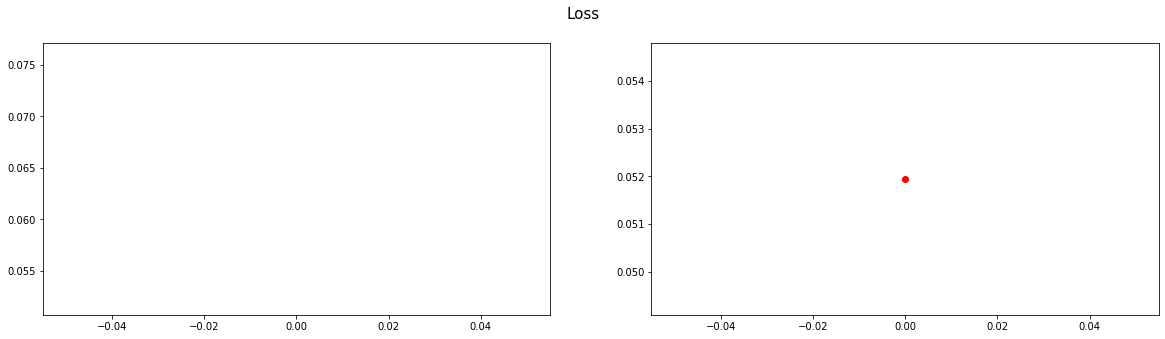

In [26]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'dr_loss.png')

In [27]:
pd.DataFrame([train_loss_list,valid_loss_list]).to_csv(result_folder + f'dr_loss.csv', index=0)

### Feature Map

In [28]:
checkpoint = torch.load(result_folder + 'dr-capsule-ecg-best.pt')
model.load_state_dict(checkpoint['model_state_dict']) #, strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['loss']
print(checkpoint['epoch'], checkpoint['loss'], checkpoint['acc'])

0 0.051947588880741316 0.9393385711675498


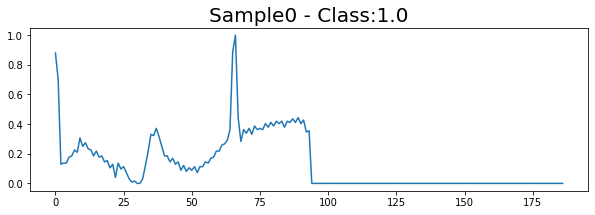

In [ ]:
model = model.eval()
num = 0
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device)
        
        plt.figure(figsize=(10,3))
        plt.plot(x[0,:,:].squeeze().detach().cpu().numpy())
        plt.title("Sample0 - Class:"+str(y[0].item()), fontsize=20)
        plt.show()
        
        class_num = int(y[0].item())

        #classes, recon = model(x, visualize=True, num = num, class_num=class_num)
        if i == 0:
            classes, recon = model(x, visualize=True, num = num, class_num=class_num)
            break

### Performance Evaluation

In [ ]:
reconstruction = []
predictions = []
prob= []
answers = []
labels = []
test_loss = []
mse_loss = []
with torch.no_grad():
    for (x, y) in tqdm(test_loader, leave=False):
        x = x.to(device)
        y = y.to(device)

        answers.extend(x.squeeze().detach().cpu().numpy())
        labels.extend(y.detach().cpu().numpy())

        y_onehot = torch.zeros(y.size(0), 5).scatter_(1, torch.Tensor(y.view(-1,1).detach().cpu()).type(torch.int64), 1.)  # change to one-hot coding
        y_onehot = y_onehot.to(device)

        classes, recon = model(x)

        loss = caps_loss(y_onehot, classes, x, recon, 0.0005*187)
        loss2 = nn.MSELoss()(recon.squeeze(), x.squeeze())

        reconstruction.extend(recon.squeeze().detach().cpu().numpy())
        predictions.extend(torch.max(classes,1)[1].detach().cpu().numpy())
        prob.extend(classes.detach().cpu().numpy())
        test_loss.append(loss.item()) 
        mse_loss.append(loss2.item())

test_loss = np.mean(test_loss)
mse_loss = np.mean(mse_loss)
test_acc = accuracy_score(labels, predictions)
f1score = f1_score(labels, predictions, average='weighted')
print(f'test loss: {test_loss} / {mse_loss} / test acc: {test_acc} / {f1score}')

In [ ]:
result_ans = pd.DataFrame(answers)
result_recon = pd.DataFrame(reconstruction)

result_ans.to_csv(result_folder + f'result_recon_ans.csv')
result_recon.to_csv(result_folder + f'result_recon.csv')

In [ ]:
result_label = pd.DataFrame([labels, predictions])
result_pred = pd.DataFrame([predictions, prob])

result_label.to_csv(result_folder + f'classi_pred_label.csv')
result_pred.to_csv(result_folder + f'classi_pred.csv')

In [ ]:
result_label.T.iloc[0:2]

In [ ]:
result_label.T.iloc[63:65]

In [ ]:
result_label.T.iloc[127:129]

In [ ]:
for i in range(3):
    plt.figure(figsize=(10,3))
    plt.plot(answers[i], c='black', ls=':', label='ground truth')
    plt.plot(reconstruction[i], c = 'blue', label='recon')
    plt.xlabel("Time", fontsize=10)
    plt.ylabel("Value", fontsize=10)
    plt.title(f"Sample {i} Reconstruction", fontsize=15)
    plt.legend()
    plt.savefig(result_folder + f'recon_sample{i}')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_label, y_pred, normalized=True):
    mat = confusion_matrix(y_label, y_pred)
    cmn = mat.astype('float')
    if normalized:
        cmn = cmn / mat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')
    plt.ylabel('Actual', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.title("Confusion Matrix (%)", fontsize=15)
    plt.savefig(result_folder + 'dr_confmatrix.png')

In [ ]:
plot_confusion_matrix(labels, predictions)

In [ ]:
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.ylabel('Actual', fontsize=10)
plt.xlabel('Predicted', fontsize=10)
plt.title("Confusion Matrix (Count)", fontsize=15)
plt.savefig(result_folder + 'dr_confmatrix2.png')

## Manual Attack

In [ ]:
checkpoint = torch.load(result_folder + 'dr-capsule-ecg-best.pt')
model.load_state_dict(checkpoint['model_state_dict']) #, strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['loss']
print(checkpoint['epoch'], checkpoint['loss'], checkpoint['acc'])

In [ ]:
import copy
def offset(input_, offset=0.1, window=35, num_sample=1,
           random_noise=True, max_rand_noise=0.01, label_last_col=False, 
           multi_var=0, device=None):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...)
    offset: constant value in the range of 0-1, which will be plus added.
    window: time window to be attacked.
    num_sample: number of records to be attacked.
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start, and end]
    """
    x = copy.deepcopy(input_)
    assert window > 0 and window < x.shape[1], "Incorrect range of window"
    assert offset >= 0 and offset <= 1, "Incorrect range of offset value"
    if label_last_col==True:
        if len(x.shape)>2:
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else:
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]

    idxs = range(num_sample)
    start_idx = np.random.randint(0, x.shape[1]-window, num_sample)
    indices = np.stack((idxs, start_idx, start_idx + window), axis=1)    
    
    if multi_var != 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window, multi_var))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window, multi_var))
        for p, sensor_idx in enumerate(sensor_idxs):
            for j, [i, start_idx, end_idx] in enumerate(indices):
                x[i, start_idx:end_idx, sensor_idx] += torch.as_tensor(offset).to(device) + torch.Tensor(noise[j,:,p]).to(device)
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window))
        for j, [i, start_idx, end_idx] in enumerate(indices):
            x.iloc[i,start_idx:end_idx] += offset + noise[j,:]
            
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
    
        return x, indices
    
    
def drift(input_, scale=0.1, window=35, num_sample=1, type_='increasing', 
          random_noise=True, max_rand_noise=0.01, label_last_col=False,
          multi_var=0, device=None):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...)
    scale: constant value in the range of 0-1, which will be plus increasingly added.
    window: time window to be attacked.
    num_sample: number of records to be attacked.
    type: options consists of 'increasing' and 'decreasing'
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start, and end]
    """
    x = copy.deepcopy(input_)
    assert window > 0 and window < x.shape[1], "Incorrect range of window"
    assert scale >= 0 and scale <= 1, "Incorrect range of scale value"
    
    if label_last_col==True:
        if len(x.shape)>2:
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else:
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]
    idxs = range(num_sample)
    start_idx = np.random.randint(0, x.shape[1]-window, num_sample)
    if len(x.shape)<3:
        start_idx = np.random.randint(0, x.shape[1]//2, num_sample)
    indices = np.stack((idxs, start_idx, start_idx + window), axis=1)

    if multi_var > 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window, multi_var))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window, multi_var))
        f = np.linspace(start=0, stop=scale, num=window) 
        if type_ =='decreasing':
            f = -f
        for p, sensor_idx in enumerate(sensor_idxs):
            for j, [i, start_idx, end_idx] in enumerate(indices):
                x[i, start_idx:end_idx, sensor_idx] += torch.Tensor(f).to(device) + torch.Tensor(noise[j,:,p]).to(device)
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window))
        f = np.linspace(start=0, stop=scale, num=window) 
        if type_ =='decreasing':
            f = -f
        for j, [i, start_idx, end_idx] in enumerate(indices):
            x.iloc[i, start_idx:end_idx] += f + noise[j,:]
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
        return x, indices
    

def lagging(input_, lag_time=15, num_sample=1, multi_var=0, type_='backward',
            random_noise=True, max_rand_noise=0.01, label_last_col=False, device=None):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...).
    lag_time: integer which is lagging duration.
    num_sample: number of records to be attacked.
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start]
    """
    x = copy.deepcopy(input_)
    assert lag_time >= 0, "Incorrect range of lag time"
#     assert type(lag_time) is int, "Incorrect data type of lag time"
    if label_last_col==True:
        if len(x.shape)>2: # multivariate
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else: #univariate
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]
    
    idxs = range(num_sample)
    if type_=='backward':
        start_idx = np.random.randint(lag_time, x.shape[1]-2*lag_time, num_sample)
        if len(x.shape)<3:
            start_idx = np.random.randint(lag_time, x.shape[1]//2, num_sample)
    else: # 'forward'
        start_idx = np.random.randint(2*lag_time, x.shape[1]-lag_time, num_sample)
        if len(x.shape)<3:
            start_idx = np.random.randint(lag_time, x.shape[1]//2, num_sample)
    indices = np.stack((idxs, start_idx), axis=1)            
    if multi_var > 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        
        for _, [i, start_idx] in enumerate(indices):
            if type_=='backward':
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                for p, sensor_idx in enumerate(sensor_idxs): 
                    x[i,start_idx:x.shape[1],sensor_idx] = copy.deepcopy(x[i,start_idx-lag_time:x.shape[1]-lag_time,sensor_idx])
                    x[i,start_idx-lag_time:start_idx,sensor_idx] = copy.deepcopy(x[i,start_idx-lag_time,sensor_idx])
                    x[i,start_idx-lag_time:x.shape[1],sensor_idx] += torch.Tensor(noise[:,p]).to(device)
            else: # 'forward'
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                for p, sensor_idx in enumerate(sensor_idxs): 
                    x[i,start_idx-lag_time:x.shape[1]-lag_time,sensor_idx] = x[i,start_idx:x.shape[1],sensor_idx]
                    x[i,x.shape[1]-lag_time:x.shape[1],sensor_idx] = x[i,x.shape[1]-lag_time,sensor_idx]
                    x[i,start_idx-lag_time:x.shape[1],sensor_idx] += torch.Tensor(noise[:,p]).to(device)
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        for _, [i, start_idx] in enumerate(indices):
            if type_=='backward':
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x.iloc[i,start_idx-lag_time:x.shape[1]].shape[0]))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x.iloc[i,start_idx-lag_tim:x.shape[1]].shape[0]))
                x.iloc[i,start_idx-lag_time:x.shape[1]] = x.iloc[i,start_idx-lag_time:x.shape[1]].shift(periods=lag_time, fill_value=x.iloc[i,start_idx-lag_time])
                x.iloc[i,start_idx-lag_time:x.shape[1]] += noise
            else:
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x.iloc[i,start_idx:x.shape[1]].shape[0]))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x.iloc[i,start_idx:x.shape[1]].shape[0]))
                x.iloc[i,start_idx:x.shape[1]] = x.iloc[i,start_idx:x.shape[1]].shift(periods=-lag_time-1, fill_value=0)
                x.iloc[i,start_idx:x.shape[1]] += noise     
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
        return x, indices

In [ ]:
offsets, offset_idx = offset(df_test, offset=0.1, window=55, num_sample=df_test.shape[0], 
                             max_rand_noise=0.01, label_last_col=True)
increasing, increase_idx = drift(df_test, scale=0.2, window=55, num_sample=df_test.shape[0], type_='increasing',
                                     max_rand_noise=0.01, label_last_col=True)
decreasing, decrease_idx = drift(df_test, scale=0.2, window=55, num_sample=df_test.shape[0], type_='decreasing',
                                     max_rand_noise=0.01, label_last_col=True)
backward, backward_idx = lagging(df_test, lag_time=10, num_sample=df_test.shape[0], type_="backward", 
                                     max_rand_noise=0.01, label_last_col=True)
forward, forward_idx   = lagging(df_test, lag_time=10, num_sample=df_test.shape[0], type_="forward", 
                                     max_rand_noise=0.01, label_last_col=True)

offset_test_dataset = MyDataset(offsets.values)
increasing_test_dataset = MyDataset(increasing.values)
decreasing_test_dataset = MyDataset(decreasing.values)
backward_test_dataset = MyDataset(backward.values)
forward_test_dataset = MyDataset(forward.values)

offset_test_loader = torch.utils.data.DataLoader(offset_test_dataset, batch_size=batch_size, 
                                                 drop_last=False, 
                                                 num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

increasing_test_loader = torch.utils.data.DataLoader(increasing_test_dataset, batch_size=batch_size, 
                                                 drop_last=False, 
                                                 num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
decreasing_test_loader = torch.utils.data.DataLoader(decreasing_test_dataset, batch_size=batch_size, 
                                                 drop_last=False, 
                                                 num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
backward_test_loader = torch.utils.data.DataLoader(backward_test_dataset, batch_size=batch_size, 
                                                 drop_last=False, 
                                                 num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
forward_test_loader = torch.utils.data.DataLoader(forward_test_dataset, batch_size=batch_size, 
                                                 drop_last=False, 
                                                 num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

In [ ]:
plt.plot(offsets.iloc[offset_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[offset_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Offset Manual Attack", fontsize=15)
plt.show()
plt.plot(increasing.iloc[increase_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[increase_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Increasing Manual Attack", fontsize=15)
plt.show()
plt.plot(decreasing.iloc[decrease_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[decrease_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Decreasing Manual Attack", fontsize=15)
plt.show()
np.random.seed(0)
plt.plot(forward.iloc[forward_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[forward_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Forward Manual Attack", fontsize=15)
plt.show()
plt.plot(forward.iloc[backward_idx[0,0],:-1], label='attack')
plt.plot(df_test.iloc[backward_idx[0,0],:-1], label='original')
plt.legend()
plt.title("Backward Manual Attack", fontsize=15)
plt.show()

In [ ]:
def attack_inference(model, test_loader, attack):
    model = model.eval()
    test_loss = []
    predictions = []
    answers = []
    reconstruction = []
    labels = []
    prob = []
    with torch.no_grad():
        for (x, y) in tqdm(test_loader, leave=False):
            x = x.to(device)
            y = y.to(device)

            answers.extend(x.squeeze().detach().cpu().numpy())
            labels.extend(y.detach().cpu().numpy())

            y_onehot = torch.zeros(y.size(0), 5).scatter_(1, torch.Tensor(y.view(-1,1).detach().cpu()).type(torch.int64), 1.)  # change to one-hot coding
            y_onehot = y_onehot.to(device)

            classes, recon = model(x)

            loss = caps_loss(y_onehot, classes, x, recon, 0.0005)

            reconstruction.extend(recon.squeeze().detach().cpu().numpy())
            predictions.extend(torch.max(classes,1)[1].detach().cpu().numpy())
            prob.extend(classes.detach().cpu().numpy())
            test_loss.append(loss.item())    

    test_loss = np.mean(test_loss)
    acc = accuracy_score(labels, predictions)
    f1score = f1_score(labels, predictions, average='weighted')
    print (f'{attack} Accuracy/test {acc} / {f1score}')
    
    return answers, reconstruction, labels, predictions, prob

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_max(answers, predictions, attack):
    cm = confusion_matrix(answers, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.ylabel('Actual', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.title("Confusion Matrix (Count)", fontsize=15)
    plt.savefig(attack_result_folder + f'cnn_dr_{attack}_confmatrix2.png')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_label, y_pred, attack, normalized=True):
    mat = confusion_matrix(y_label, y_pred)
    cmn = mat.astype('float')
    if normalized:
        cmn = cmn / mat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues')
    plt.ylabel('Actual', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.title("Confusion Matrix (%)", fontsize=15)
    plt.savefig(attack_result_folder + f'cnn_dr_{attack}_confmatrix.png')

In [ ]:
def np_mse(A, B):
    return (np.square(A - B)).mean()

In [ ]:
for attack in ['offset', 'increasing', 'decreasing', 'backward', 'forward']:
    if attack == 'offset':
        attack_loader = offset_test_loader 
    if attack == 'increasing':
        attack_loader = increasing_test_loader 
    if attack == 'decreasing':
        attack_loader = decreasing_test_loader 
    if attack == 'backward':
        attack_loader = backward_test_loader 
    if attack == 'forward':
        attack_loader = forward_test_loader 
        
    answers, reconstruction, labels, predictions, prob = attack_inference(model, attack_loader, attack)
    print(np_mse(np.array(answers), np.array(reconstruction)))
    conf_max(labels, predictions, attack)
    plot_confusion_matrix(labels, predictions, attack)
    
    result_ans_attack = pd.DataFrame(answers)
    result_recon_attack = pd.DataFrame(reconstruction)
    result_ans_attack.to_csv(attack_result_folder + f'dr_{attack}_reconstruction.csv')
    result_recon_attack.to_csv(attack_result_folder + f'dr_{attack}_reconstruction_pred.csv')
    
    for i in range(3):
        plt.figure(figsize=(10,3))
        plt.plot(result_ans.iloc[i, :], c='black', ls=':', label = 'GroundTruth')
        plt.plot(result_ans_attack.iloc[i, :], c='blue', ls=':', label='Manual Attack')
        plt.plot(result_recon_attack.iloc[i, :], c='red', label='Manual Attack Recon')
        plt.legend()
        plt.show()
    
    result_label_attack = pd.DataFrame([labels, predictions])
    result_pred_attack = pd.DataFrame([predictions, prob])
    result_label_attack.to_csv(attack_result_folder + f'dr_{attack}_classification.csv')
    result_pred_attack.to_csv(attack_result_folder + f'dr_{attack}_classification_prob.csv')

def attack_feature_map(model, test_loader, true_loader, attack, idx):
    model = model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            if i < (idx[0][0])//64:
                pass
            else:
                x = x.to(device)
                y = y.to(device)
                for i, (x_, y_) in enumerate(true_loader):
                    if i < (idx[0][0])//64:
                        pass
                    else:
                        x_true = x_.to(device)
                        y_true = y_.to(device)
                        break
                        
                print(x.shape)

                label = (idx[0][0]) - (idx[0][0])//64 * 64
                plt.figure(figsize=(10,3))
                plt.plot(x[label,:,:].transpose(0,1).detach().cpu().numpy(), c = 'blue')
                plt.plot(x_true[label,:,:].transpose(0,1).detach().cpu().numpy(), c = 'black', ls=':')
                plt.title(f"Sample{idx[0][0]} - Class:"+str(y[label].item()), fontsize=20)
                plt.show()
                
                class_num = int(y[label].item())

                classes, recon = model(x, None, True, label, class_num, attack)

                break

attack_feature_map(model,offset_test_loader, test_loader, 'offset_attack', offset_idx)

attack_feature_map(model,increasing_test_loader, test_loader, 'increasing_attack', increase_idx)

attack_feature_map(model,decreasing_test_loader, test_loader, 'decreasing_attack', decrease_idx)


attack_feature_map(model,laggings_test_loader, test_loader, 'laggings_attack', lag_idx)

def attack_feature_map_true(model, test_loader, true_loader, attack, idx):
    model = model.eval()
    with torch.no_grad():
        for i, (x_, y_) in enumerate(true_loader):
            if i < (idx[0][0])//64:
                pass
            else:
                x_true = x_.to(device)
                y_true = y_.to(device)

                label = (idx[0][0]) - (idx[0][0])//64 * 64
                plt.figure(figsize=(10,3))
                #plt.plot(x[label,:,:].transpose(0,1).detach().cpu().numpy(), c = 'blue')
                plt.plot(x_true[label,:,:].transpose(0,1).detach().cpu().numpy(), c = 'black', ls=':')
                plt.title(f"Sample{idx[0][0]} - Class:"+str(y_true[label].item()), fontsize=20)
                plt.show()

                class_num = int(y_true[label].item())

                classes, recon = model(x_true, None, True, label, class_num, attack)
                break

attack_feature_map_true(model,offset_test_loader, test_loader, 'offset_attack', offset_idx)
attack_feature_map_true(model,increasing_test_loader, test_loader, 'increasing_attack', increase_idx)
attack_feature_map_true(model,decreasing_test_loader, test_loader, 'decreasing_attack', decrease_idx)
attack_feature_map_true(model,laggings_test_loader, test_loader, 'laggings_attack', lag_idx)

## Balck Box Attack - fgsm

In [ ]:
fgsm_attack = pd.read_csv(data_folder +'ECG_adv-eps-0.01-test.csv')
fgsm_attack = fgsm_attack.loc[df_test.index]
len(fgsm_attack)

In [ ]:
fgsm_test_dataset = MyDataset(fgsm_attack.values)
fgsm_test_loader = torch.utils.data.DataLoader(fgsm_test_dataset, batch_size=batch_size, 
                                     drop_last=False, 
                                     num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

In [ ]:
attack = 'fgsm'
answers, reconstruction, labels, predictions, prob = attack_inference(model, fgsm_test_loader, attack)
print(np_mse(np.array(answers), np.array(reconstruction)))
conf_max(labels, predictions, attack)
plot_confusion_matrix(labels, predictions, attack)
    
result_ans_attack = pd.DataFrame(answers)
result_recon_attack = pd.DataFrame(reconstruction)
result_ans_attack.to_csv(attack_result_folder + f'dr_{attack}_reconstruction.csv')
result_recon_attack.to_csv(attack_result_folder + f'dr_{attack}_reconstruction_pred.csv')
    
for i in range(3):
    plt.figure(figsize=(10,3))
    plt.plot(result_ans.iloc[i, :], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_ans_attack.iloc[i, :], c='blue', ls=':', label='Manual Attack')
    plt.plot(result_recon_attack.iloc[i, :], c='red', label='Manual Attack Recon')
    plt.legend()
    plt.show()
    
result_label_attack = pd.DataFrame([labels, predictions])
result_pred_attack = pd.DataFrame([predictions, prob])
result_label_attack.to_csv(attack_result_folder + f'dr_{attack}_classification.csv')
result_pred_attack.to_csv(attack_result_folder + f'dr_{attack}_classification_prob.csv')